<a href="https://colab.research.google.com/github/zdzichumis/Object-tracking-code/blob/main/Analiza%20wynik%C3%B3w%20z%20kierunkiem%20ruchu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [300]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [301]:
def check_if_inside(point, bbox):
    bx0, by0, bx1, by1 = bbox
    x, y = point
    return (bx0 <= x <= bx1) and (by0 <= y <= by1)

In [302]:
fps = 30
true_points = pd.read_csv("interpolated2min_04_30_18h_18.csv")

#tracking_bbox = pd.read_csv("track_04_30_18h_18_default_model.csv")
tracking_bbox = pd.read_csv("track_04_30_18h_18_acceleration_model.csv")

tracking_bbox = tracking_bbox[tracking_bbox["detected"] == 1]
tracking_bbox.head()

,x0,y0,x1,y1,label,detected,frame
0,1073,501,1134,537,1,1,0
1,951,253,975,272,2,1,0
2,199,575,457,717,3,1,0
3,1073,501,1134,537,1,1,1
4,949,253,974,272,2,1,1


## ograniczanie danych

#### do obszaru zainteresowania na czerwono

In [303]:
main_area = [(0,720), (75, 288), (166,243), (1015,200), (1082, 241),
(1207, 512), (1065, 720)]
top_area = [(972, 390), (710, 310), (1135, 116), (1205, 161)]
bottom_area = [(1,661),(377,450),(807, 589),(640,719), (0,720)]
left_area = [(397,450),(591,337), (0,149), (1,293)]
right_area = [(755,598),(971,390), (1270, 505), (1259,684)]

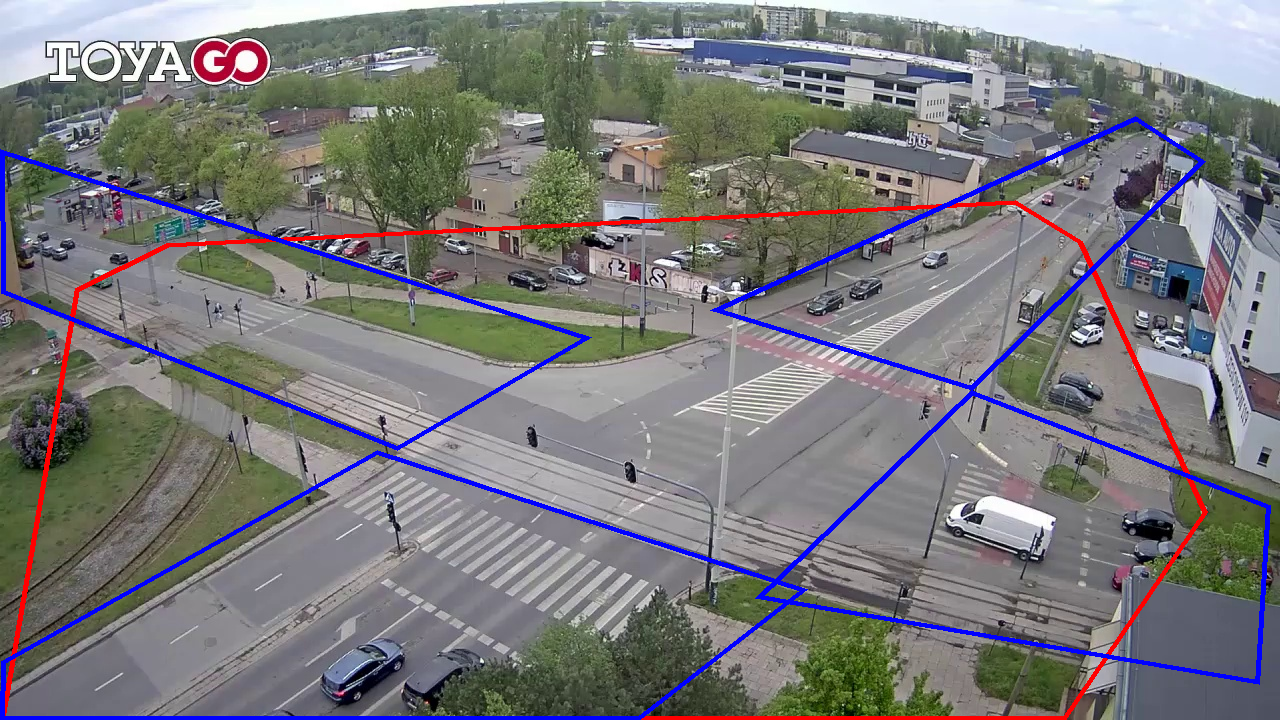

In [304]:
img = Image.open("reference.jpg")
img1 = ImageDraw.Draw(img)
img1.polygon(main_area, outline ="red", width=5)
img1.polygon(bottom_area, outline ="blue", width=5)
img1.polygon(top_area, outline ="blue", width=5)
img1.polygon(left_area, outline ="blue", width=5)
img1.polygon(right_area, outline ="blue", width=5)
img

$$ta+(1-t)b = (c_x, \cdot)$$

$$b+t(a-b) = (c_x, \cdot)$$

$$t^\ast = \frac{c_x-b_x}{a_x-b_x}, \ t^\ast(a-b) + b > c_y$$

In [305]:
def is_inner(px,py, polygon=main_area, verbose=False):
    points = polygon + [polygon[0]]
    counter = 0
    for a,b in zip(points, points[1:]):
        ax, ay = a
        bx, by = b
        ax, ay, bx, by = ax + 0.1, ay + 0.1, bx + 0.1, by + 0.1
        t = (px - bx)/(ax - bx)
        if 0 <= t < 1 and t * (ay - by) + by >= py:
            counter += 1
        if verbose:
            print(a, b, t)
    if verbose:
        print(counter)
    return (counter % 2) != 0


In [306]:
#####
#####  TAKES TRUE POINTS ONLY FROM INSIDE THE AREA OF INTEREST
#####

true_points = true_points[true_points.apply(lambda row: is_inner(row["x"], row["y"]), axis=1)]

#### do pierwszych dwóch minut

In [307]:
#####
#####  TAKES ONLY FRAMES FROM THE FIRST TWO MINUTES
#####

true_points = true_points[true_points["frame"] <= 30*60*2]
tracking_bbox = tracking_bbox[tracking_bbox["frame"] <= fps*60*2]
tracking_bbox['x'] = (tracking_bbox['x0'] + tracking_bbox['x1'])/2
tracking_bbox['y'] = (tracking_bbox['y0'] + tracking_bbox['y1'])/2

<ipython-input-307-194f21474605>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_bbox['x'] = (tracking_bbox['x0'] + tracking_bbox['x1'])/2
<ipython-input-307-194f21474605>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracking_bbox['y'] = (tracking_bbox['y0'] + tracking_bbox['y1'])/2


## Dodanie informacji o kierunku ruchu

 BRAK JESZCZE INFORMACJI O ZWROCIE, czyli do `BL` zaliczam samochody jadące z dołu w lewo, albo jadące z lewej strony w dół.

In [308]:
first_frame = tracking_bbox[["label", "frame"]][tracking_bbox["detected"] == 1].groupby("label").min().rename(columns={"frame": "first frame"})
last_frame = tracking_bbox[["label", "frame"]][tracking_bbox["detected"] == 1].groupby("label").max()
frame_range = first_frame
frame_range["last frame"] = last_frame
frame_range.reset_index()

,label,first frame,last frame
0,1,0,1504
1,2,0,2515
2,3,0,361
3,4,97,1537
4,6,170,393
...,...,...,...
65,78,3007,3013
66,79,3017,3193
67,80,3225,3390
68,81,3476,3600


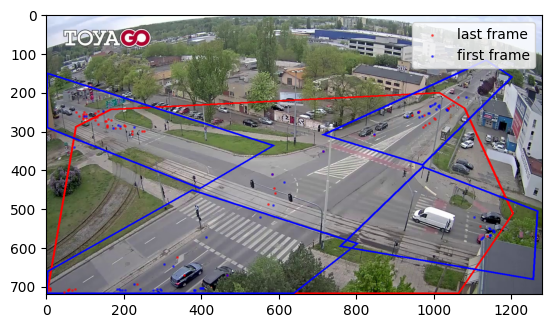

In [309]:
plt.imshow(img)
last_frames = tracking_bbox[tracking_bbox["detected"] == 1].merge(frame_range, left_on=["label","frame"],
                    right_on=["label", "last frame"]).drop(columns=["last frame", "first frame"])
plt.scatter(last_frames["x"], last_frames["y"], s=1, color="red", label="last frame", alpha=0.5)
first_frames = tracking_bbox[tracking_bbox["detected"] == 1].merge(frame_range, left_on=["label","frame"],
                    right_on=["label", "first frame"]).drop(columns=["last frame", "first frame"])#[["x","y"]]
plt.scatter(first_frames["x"], first_frames["y"], s=1, color="blue", label="first frame", alpha=0.5)
plt.legend()

In [310]:
directions = first_frames.merge(last_frames, on="label", suffixes=[" first", " last"])
directions["x first"]

,x first
0,1103.5
1,963.0
2,328.0
3,1154.0
4,412.5
...,...
65,985.5
66,968.5
67,405.0
68,189.0


In [311]:
def _check(row, suffix=""):
    for name, area in [("L", left_area), ("R", right_area), ("B", bottom_area), ("T", top_area)]:
        if is_inner(row["x" + suffix], row["y" + suffix], area):
            return name
    return "0"

In [312]:
directions["path type"] = directions.apply(lambda row: _check(row, suffix=" first"), axis=1) + directions.apply(lambda row: _check(row, suffix=" last"), axis=1)
directions["path type"].value_counts()

,count
path type,
BL,11
TB,9
RL,9
TT,9
LL,7
BT,7
BB,4
00,3
TL,3


In [313]:
true_points = pd.merge(directions[["label", "path type"]], true_points, on="label")
true_points

,label,path type,x,y,frame
0,1,RT,1031,221,105
1,1,RT,1023,226,120
2,1,RT,1013,234,135
3,1,RT,1004,241,150
4,1,RT,994,249,165
...,...,...,...,...,...
33518,46,RL,237,688,3595
33519,46,RL,237,688,3596
33520,46,RL,237,688,3597
33521,46,RL,237,688,3598


### Sprawdzenie jak wyglądają typy trajektorii

In [318]:
def check_path(points):
    plt.title("true points")
    plt.scatter(points["x"], (-1)*points["y"], s=1)
    for polygon in [left_area, right_area, bottom_area, top_area]:
        area = np.array(polygon + [polygon[0]])
        print(-area[:, 1])
        plt.plot(-area[:, 1], -area[:, 1], color="green")
    plt.xlim(0, 1280)
    plt.ylim(-720,-150)

       label path type    x    y  frame
13156     17        00  250  706    585
13157     17        00  292  666    600
13158     17        00  341  626    615
13159     17        00  396  581    630
13160     17        00  448  540    645
...      ...       ...  ...  ...    ...
23311     22        00  116  273   2849
23312     22        00  113  272   2851
23313     22        00  112  272   2852
23314     22        00  111  272   2853
23315     22        00  110  271   2854

[2059 rows x 5 columns]
[-450 -337 -149 -293 -450]
[-598 -390 -505 -684 -598]
[-661 -450 -589 -719 -720 -661]
[-390 -310 -116 -161 -390]


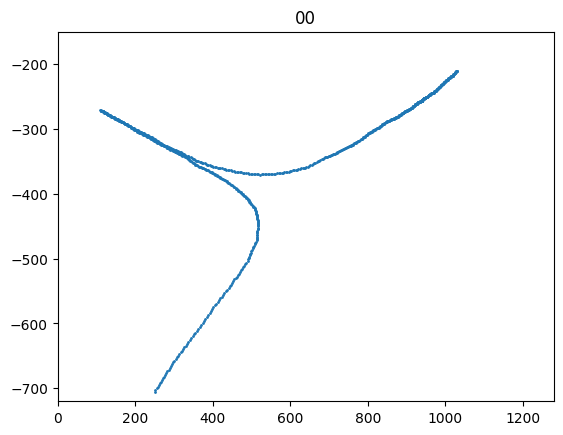

       label path type     x    y  frame
11775     14        0L   337  689    480
11776     14        0L   368  665    495
11777     14        0L   392  643    510
11778     14        0L   416  626    525
11779     14        0L   433  610    540
...      ...       ...   ...  ...    ...
33427     45        0L  1051  227   3464
33428     45        0L  1052  226   3466
33429     45        0L  1053  225   3467
33430     45        0L  1053  225   3468
33431     45        0L  1054  224   3469

[816 rows x 5 columns]
[-450 -337 -149 -293 -450]
[-598 -390 -505 -684 -598]
[-661 -450 -589 -719 -720 -661]
[-390 -310 -116 -161 -390]


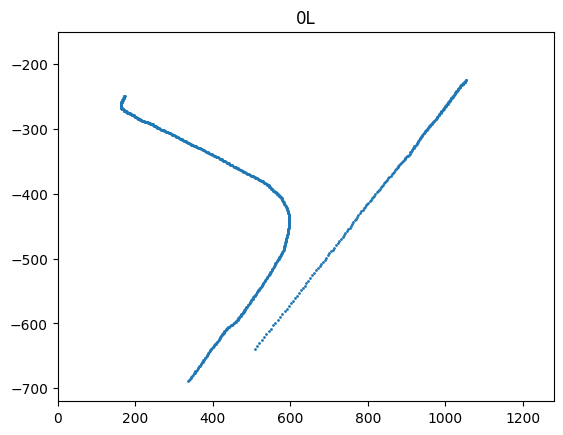

       label path type    x    y  frame
4177       3        B0  426  616      0
4178       3        B0  276  710      0
4179       3        B0  426  616     15
4180       3        B0  276  710     15
4181       3        B0  426  616     30
...      ...       ...  ...  ...    ...
12972     15        B0  170  248   1165
12973     15        B0  170  247   1166
12974     15        B0  171  247   1167
12975     15        B0  171  246   1168
12976     15        B0  172  246   1169

[1413 rows x 5 columns]
[-450 -337 -149 -293 -450]
[-598 -390 -505 -684 -598]
[-661 -450 -589 -719 -720 -661]
[-390 -310 -116 -161 -390]


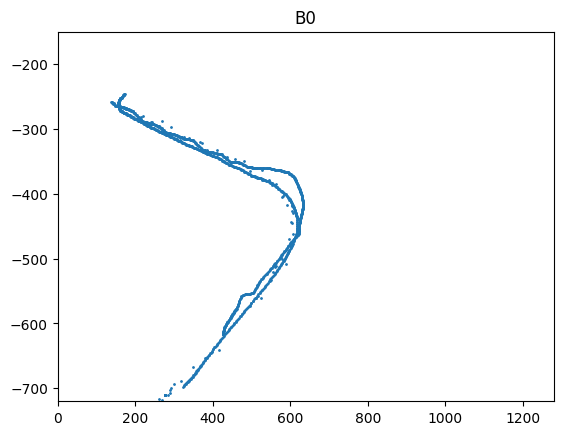

       label path type     x    y  frame
25729     29        BB  1124  569   1335
25730     29        BB  1082  558   1350
25731     29        BB  1040  547   1365
25732     29        BB   987  536   1380
25733     29        BB   930  524   1395
...      ...       ...   ...  ...    ...
28816     35        BB   189  643   2740
28817     35        BB   184  646   2741
28818     35        BB   179  649   2742
28819     35        BB   174  652   2743
28820     35        BB   169  655   2744

[1411 rows x 5 columns]
[-450 -337 -149 -293 -450]
[-598 -390 -505 -684 -598]
[-661 -450 -589 -719 -720 -661]
[-390 -310 -116 -161 -390]


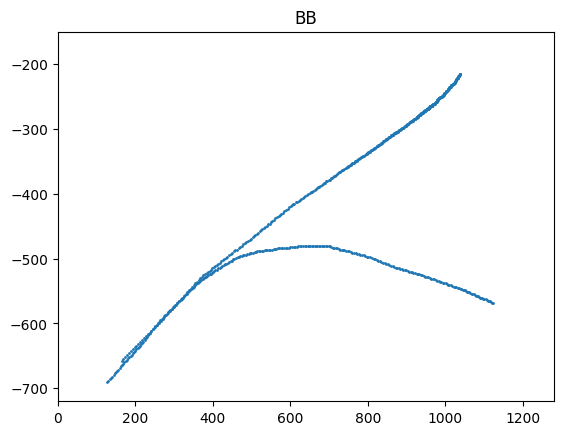

       label path type     x    y  frame
5437       6        BL  1158  553    120
5438       6        BL  1151  551    135
5439       6        BL  1148  550    150
5440       6        BL  1148  550    165
5441       6        BL  1148  550    180
...      ...       ...   ...  ...    ...
25724     26        BL   117  271   1593
25725     26        BL   116  270   1594
25726     26        BL   116  270   1595
25727     26        BL   115  270   1596
25728     26        BL   114  269   1597

[9114 rows x 5 columns]
[-450 -337 -149 -293 -450]
[-598 -390 -505 -684 -598]
[-661 -450 -589 -719 -720 -661]
[-390 -310 -116 -161 -390]


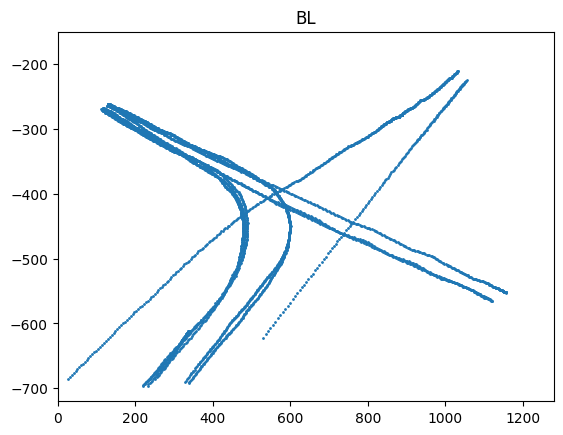

       label path type     x    y  frame
23716     25        BT  1027  218   1335
23717     25        BT  1018  222   1350
23718     25        BT  1008  224   1365
23719     25        BT  1001  230   1380
23720     25        BT   992  234   1395
...      ...       ...   ...  ...    ...
25341     25        BT   115  273   2946
25342     25        BT   114  272   2947
25343     25        BT   112  272   2948
25344     25        BT   111  272   2949
25345     25        BT   110  271   2950

[1630 rows x 5 columns]
[-450 -337 -149 -293 -450]
[-598 -390 -505 -684 -598]
[-661 -450 -589 -719 -720 -661]
[-390 -310 -116 -161 -390]


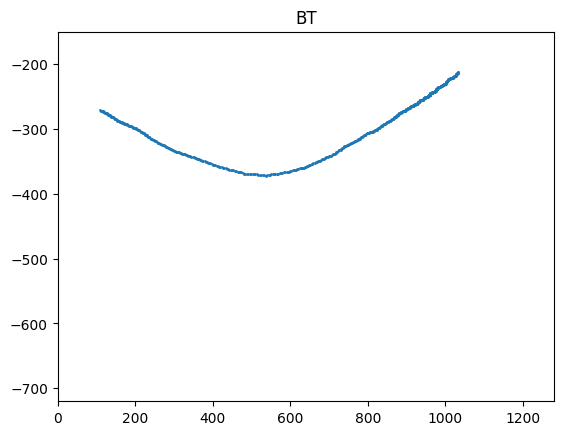

       label path type     x    y  frame
13494     18        LL  1039  218    870
13495     18        LL  1031  223    885
13496     18        LL  1025  229    900
13497     18        LL  1015  234    915
13498     18        LL  1007  240    930
...      ...       ...   ...  ...    ...
27122     32        LL   132  262   1972
27123     32        LL   132  262   1973
27124     32        LL   131  262   1974
27125     32        LL   131  262   1975
27126     32        LL   130  261   1976

[4430 rows x 5 columns]
[-450 -337 -149 -293 -450]
[-598 -390 -505 -684 -598]
[-661 -450 -589 -719 -720 -661]
[-390 -310 -116 -161 -390]


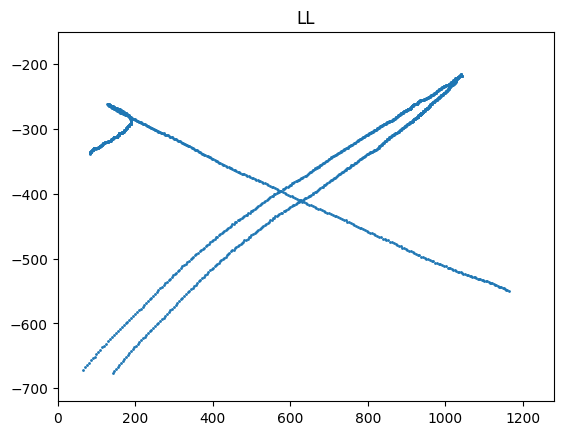

       label path type     x    y  frame
32980     44        RB  1030  221   2970
32981     44        RB  1014  235   2985
32982     44        RB   995  246   3000
32983     44        RB   971  261   3015
32984     44        RB   944  276   3030
...      ...       ...   ...  ...    ...
33197     44        RB   180  642   3175
33198     44        RB   173  646   3176
33199     44        RB   166  651   3177
33200     44        RB   159  655   3178
33201     44        RB   152  660   3179

[222 rows x 5 columns]
[-450 -337 -149 -293 -450]
[-598 -390 -505 -684 -598]
[-661 -450 -589 -719 -720 -661]
[-390 -310 -116 -161 -390]


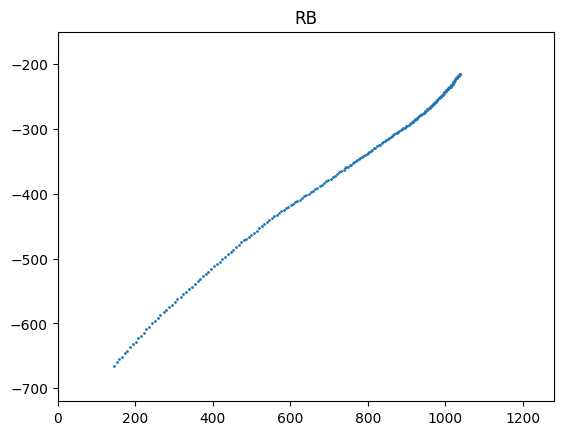

       label path type    x    y  frame
4974       4        RL  360  601      0
4975       4        RL  360  601     15
4976       4        RL  360  601     30
4977       4        RL  360  601     45
4978       4        RL  360  601     60
...      ...       ...  ...  ...    ...
33518     46        RL  237  688   3595
33519     46        RL  237  688   3596
33520     46        RL  237  688   3597
33521     46        RL  237  688   3598
33522     46        RL  237  688   3599

[3414 rows x 5 columns]
[-450 -337 -149 -293 -450]
[-598 -390 -505 -684 -598]
[-661 -450 -589 -719 -720 -661]
[-390 -310 -116 -161 -390]


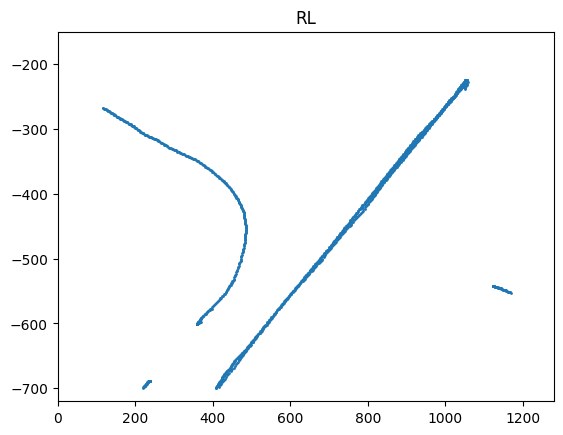

      label path type     x    y  frame
0         1        RT  1031  221    105
1         1        RT  1023  226    120
2         1        RT  1013  234    135
3         1        RT  1004  241    150
4         1        RT   994  249    165
...     ...       ...   ...  ...    ...
2559      1        RT   170  651   2650
2560      1        RT   165  654   2651
2561      1        RT   160  657   2652
2562      1        RT   154  660   2653
2563      1        RT   149  663   2654

[2564 rows x 5 columns]
[-450 -337 -149 -293 -450]
[-598 -390 -505 -684 -598]
[-661 -450 -589 -719 -720 -661]
[-390 -310 -116 -161 -390]


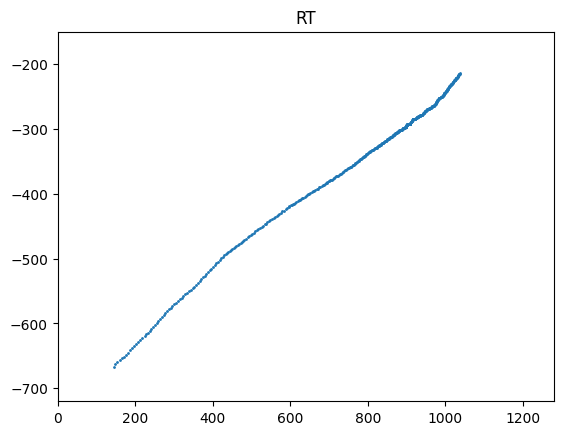

       label path type     x    y  frame
2564       2        TB  1100  514      0
2565       2        TB  1100  514     15
2566       2        TB  1100  514     30
2567       2        TB  1100  514     45
2568       2        TB  1100  514     60
...      ...       ...   ...  ...    ...
30696     37        TB    73  672   2920
30697     37        TB    68  675   2921
30698     37        TB    63  679   2922
30699     37        TB    58  682   2923
30700     37        TB    53  685   2924

[5785 rows x 5 columns]
[-450 -337 -149 -293 -450]
[-598 -390 -505 -684 -598]
[-661 -450 -589 -719 -720 -661]
[-390 -310 -116 -161 -390]


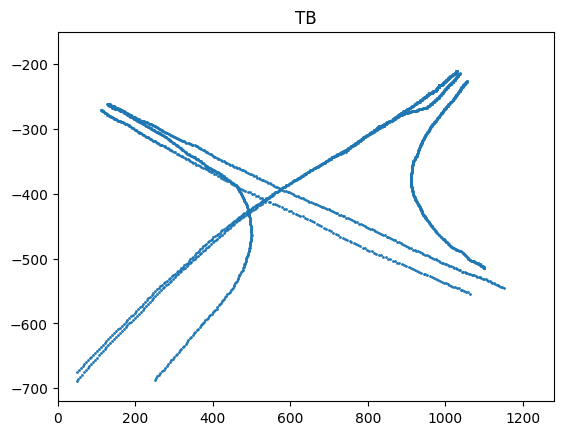

       label path type     x    y  frame
27127     33        TT  1072  556   1470
27128     33        TT   994  535   1485
27129     33        TT   911  514   1500
27130     33        TT   828  490   1515
27131     33        TT   744  469   1530
...      ...       ...   ...  ...    ...
32325     39        TT  1056  228   2838
32326     39        TT  1056  227   2839
32327     39        TT  1057  227   2840
32328     39        TT  1057  227   2841
32329     39        TT  1058  227   2842

[665 rows x 5 columns]
[-450 -337 -149 -293 -450]
[-598 -390 -505 -684 -598]
[-661 -450 -589 -719 -720 -661]
[-390 -310 -116 -161 -390]


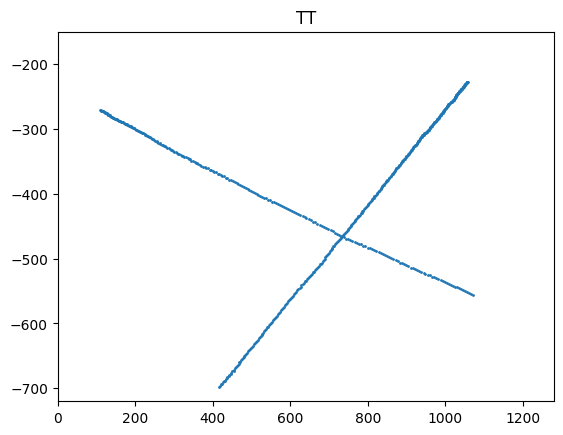

In [319]:
for _path_type, _data  in true_points.groupby("path type"):
    print(_data)
    check_path(_data)
    plt.title(_path_type)
    plt.show()

In [298]:
matching = pd.merge(true_points, tracking_bbox, on="frame", suffixes=("_true", "_pred"))
matching

,label_true,path type,x_true,y_true,frame,x0,y0,x1,y1,label_pred,detected,x_pred,y_pred
0,1,RT,1031,221,105,1073,500,1133,536,1,1,1103.0,518.0
1,1,RT,1031,221,105,198,573,456,717,3,1,327.0,645.0
2,1,RT,1031,221,105,857,291,895,316,2,1,876.0,303.5
3,1,RT,1031,221,105,1127,539,1173,571,4,1,1150.0,555.0
4,1,RT,1023,226,120,1072,500,1132,535,1,1,1102.0,517.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
406930,46,RL,237,688,3599,297,592,376,655,29,1,336.5,623.5
406931,46,RL,237,688,3599,312,632,400,710,35,1,356.0,671.0
406932,46,RL,237,688,3599,1088,528,1151,560,61,1,1119.5,544.0
406933,46,RL,237,688,3599,194,666,272,718,81,1,233.0,692.0


## Obliczenie metryk poprawności śledzenia

In [299]:
#calculate if point is inside a bbox
#(the true points are not always perfectly on the car, so I use `eps` to be more forgiving)
matching = pd.merge(true_points, tracking_bbox, on="frame", suffixes=("_true", "_pred"))
match_x = ((matching["x0"] <= matching["x"]) & (matching["x"] <= matching["x1"] ))
match_y = ((matching["y0"] <= matching["y"]) & (matching["y"] <= matching["y1"]))
matching = matching[match_x & match_y]
matched = matching.copy().drop(columns=["x0","y0","x1", "y1"])

KeyError: 'x'

In [ ]:
point_count = true_points.groupby(["label","frame"]).count().reset_index()\
                         .groupby("label").count().reset_index() \
                         .drop(columns=["path type", "x", "y"]) \
                         .rename(columns={"frame":"point count"})
point_count.head(5)

,label,point count
0,0,2506
1,1,2564
2,2,1613
3,3,721
4,4,463


In [ ]:
# check if there are any objects with 2 bbox per frame
tracking_bbox.drop(columns = ["x0", "y0", "y1"]).groupby(["label", "frame"]).count()\
             .reset_index().rename(columns={"x1": "max bbox count per object per frame"}).max()

,0
label,82
frame,3600
max bbox count per object per frame,1
detected,1


In [ ]:
bbox_count = tracking_bbox.groupby(["label"]).count().reset_index()[["label", "frame"]]\
                          .rename(columns={"frame": "bbox count"})
bbox_count.head(5)

,label,bbox count
0,1,1476
1,2,2515
2,3,359
3,4,1438
4,6,221


In [ ]:
_tmp = true_points.groupby(["label", "frame"]).count()[["x"]].reset_index().rename(columns={"x": "count true"})
matches_count = matching.groupby(["label_true", "label_pred", "frame"]).count()[["x"]].rename(columns={"x":"count match"})\
              .reset_index().merge(_tmp, left_on=["label_true", "frame"], right_on=["label", "frame"])
matches_count["count"] = (matches_count["count match"]/matches_count["count true"])
matches_count = matches_count[["label_true", "label_pred", "count"]].groupby(["label_true", "label_pred"]).sum().reset_index()
matches_count = matches_count.rename(columns={"count": "matches count"})
matches_count.head(5)

,label_true,label_pred,matches count
0,0,2,2505.0
1,0,13,1717.0
2,0,60,3.0
3,1,7,2482.0
4,2,1,1476.0


In [ ]:
IoU = matches_count.merge(point_count, left_on="label_true", right_on="label").drop(columns=["label"])
IoU = IoU.merge(bbox_count, left_on="label_pred", right_on="label").drop(columns=["label"])
IoU["IoU"] = IoU["matches count"]/(IoU["point count"] + IoU["bbox count"] - IoU["matches count"])
IoU[["label_true", "label_pred", "IoU"]].sort_values("IoU")

,label_true,label_pred,IoU
19,7,60,0.000426
7,3,6,0.001063
2,0,60,0.001197
24,9,14,0.001403
60,33,46,0.001678
...,...,...,...
18,7,13,0.972870
37,19,29,0.992179
42,23,35,0.992692
0,0,2,0.995628


*Code is based on https://github.com/JonathonLuiten/TrackEval/blob/master/trackeval/metrics/identity.py*

In [ ]:
def calculate_metrics(true_points, tracking_bbox, matched):
    num_gt_ids = len(true_points["label"].unique())
    num_tracker_ids = len(tracking_bbox["label"].unique())

    translate = pd.DataFrame(enumerate(tracking_bbox["label"].unique()), columns=["new_lebel_pred", "label_pred"])
    translate

    potential_matches_count = np.zeros((num_gt_ids, num_tracker_ids))
    _tmp = matched[["label_true", "label_pred", "frame"]].groupby(["label_true","label_pred"]).count().reset_index()\
           .merge(translate, on="label_pred").drop(columns="label_pred")
    for i, (label_true, match_count, label_pred) in _tmp.iterrows():
        potential_matches_count[label_true, label_pred] = match_count

    gt_id_count = np.zeros(num_gt_ids)
    tracker_id_count = np.zeros(num_tracker_ids)
    _tmp = true_points[["label", "frame"]].drop_duplicates().groupby("label").count().reset_index()
    for i, (gt_id, gt_count) in _tmp.iterrows():
        gt_id_count[gt_id] = gt_count
    _tmp = tracking_bbox[["label", "frame"]].groupby("label").count().reset_index()\
                      .merge(translate, left_on="label", right_on="label_pred").drop(columns=["label", "label_pred"])
    for i, (tracker_count, tracker_id) in _tmp.iterrows():
        tracker_id_count[tracker_id] = tracker_count

    from scipy.optimize import linear_sum_assignment

    res = {}

    fp_mat = np.zeros((num_gt_ids + num_tracker_ids, num_gt_ids + num_tracker_ids))
    fn_mat = np.zeros((num_gt_ids + num_tracker_ids, num_gt_ids + num_tracker_ids))
    fp_mat[num_gt_ids:, :num_tracker_ids] = 1e10
    fn_mat[:num_gt_ids, num_tracker_ids:] = 1e10
    for gt_id in range(num_gt_ids):
        fn_mat[gt_id, :num_tracker_ids] = gt_id_count[gt_id]
        fn_mat[gt_id, num_tracker_ids + gt_id] = gt_id_count[gt_id]
    for tracker_id in range(num_tracker_ids):
        fp_mat[:num_gt_ids, tracker_id] = tracker_id_count[tracker_id]
        fp_mat[tracker_id + num_gt_ids, tracker_id] = tracker_id_count[tracker_id]
    fn_mat[:num_gt_ids, :num_tracker_ids] -= potential_matches_count
    fp_mat[:num_gt_ids, :num_tracker_ids] -= potential_matches_count

    # Hungarian algorithm
    match_rows, match_cols = linear_sum_assignment(fn_mat + fp_mat)

    # Accumulate basic statistics
    res['IDFN'] = fn_mat[match_rows, match_cols].sum().astype(int)
    res['IDFP'] = fp_mat[match_rows, match_cols].sum().astype(int)
    res['IDTP'] = (gt_id_count.sum() - res['IDFN']).astype(int)

    res['IDR'] = res['IDTP'] / np.maximum(1.0, res['IDTP'] + res['IDFN'])
    res['IDP'] = res['IDTP'] / np.maximum(1.0, res['IDTP'] + res['IDFP'])
    res['IDF1'] = res['IDTP'] / np.maximum(1.0, res['IDTP'] + 0.5 * res['IDFP'] + 0.5 * res['IDFN'])
    return res

In [ ]:
#calculate if point is inside a bbox
#(the true points are not always perfectly on the car, so I use `eps` to be more forgiving)
matching = pd.merge(true_points, tracking_bbox, on="frame", suffixes=("_true", "_pred"))
match_x = ((matching["x0"] <= matching["x"]) & (matching["x"] <= matching["x1"] ))
match_y = ((matching["y0"] <= matching["y"]) & (matching["y"] <= matching["y1"]))
matching = matching[match_x & match_y]
matched = matching.copy().drop(columns=["x0","y0","x1", "y1"])

Definicje metryk:
 * `(%) matches best` - jaka część punktów pojazdu została przydzielona do obiektu (ze śledzenia), przy czym wybieramy obiekt dla któego ta część jak największa. Metryka powinna być jak największa, ale nie musi być 100%, bo brak detekcji samochodu również ma na nią wpływ.
 * `(%) matches 2nd best` - tak samo jak wyżej, tylko biorę drugi najlepszy obiekt. Metryka powinna być jak najmniejsza. Brak detekcji samochodu nie wpływa negatywnie na metrykę.
 * `(%) nondominant matches` -  podobnie jak `(%) matches best` tylko sumuje metryki dla wszystkich obiektów innych niż najlepszy (tzn. inne niż te używane w `(%) matches best`).

In [ ]:
def check_true_object_i(label_i):
    points_count = true_points["label"].value_counts()[label_i]
    time_matched = matched[matched["label_true"]== label_i]["label_pred"].value_counts()/points_count*100
    remaining = 0
    if len(time_matched) > 0:
        remaining = time_matched.sum() - float(time_matched.head(1))
    time_matched = time_matched.head(2)
    return (list(time_matched) + [0, 0])[:2] + [remaining]

object_metrics = pd.DataFrame([check_true_object_i(y) + [y]
                           for y in true_points["label"].unique()],
            columns = ["(%) matches best", "(%) matches 2nd best", "(%) nondominant matches", "true_object_id"])
object_metrics = pd.merge(object_metrics, directions, left_on="true_object_id", right_on="label")
object_metrics = object_metrics.drop(columns =["label"])
object_metrics.head(5)

<ipython-input-140-1a9ab3553bb0>:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  remaining = time_matched.sum() - float(time_matched.head(1))


,(%) matches best,(%) matches 2nd best,(%) nondominant matches,true_object_id,path type
0,99.960112,68.488233,68.607898,0,BT
1,96.801872,0.000000,0.000000,1,BT
2,91.506510,0.557967,0.557967,2,RT
3,48.306148,45.169385,46.424090,3,LB
4,47.732181,37.580994,40.172786,4,LB


In [ ]:
#Wyniki biorąc tylko  klatki z detekcją YOLO
res = calculate_metrics(true_points, tracking_bbox, matched)
average_metrics = object_metrics.drop(columns=["path type", "true_object_id"]).mean()/100
average_metrics.name = "Values"
average_metrics.index = ['Average matches best', 'Average matches 2nd best', 'Average nondominant matches']
average_metrics["Precision"] = res['IDP']
average_metrics["Recall"] = res['IDR']
average_metrics["F1"] = res['IDF1']
average_metrics

,Values
Average matches best,0.852897
Average matches 2nd best,0.062304
Average nondominant matches,0.066216
Precision,0.952845
Recall,0.872915
F1,0.911130


In [ ]:
#Wyniki biorąc wszystkie klatki (w tym z predykcjami filtru Kalmana)
res = calculate_metrics(true_points, tracking_bbox, matched)
average_metrics = object_metrics.drop(columns=["path type", "true_object_id"]).mean()/100
average_metrics.name = "Values"
average_metrics.index = ['Average matches best', 'Average matches 2nd best', 'Average nondominant matches']
average_metrics["Precision"] = res['IDP']
average_metrics["Recall"] = res['IDR']
average_metrics["F1"] = res['IDF1']
average_metrics

,Values
Average matches best,0.896933
Average matches 2nd best,0.073617
Average nondominant matches,0.080883
Precision,0.918634
Recall,0.896449
F1,0.907406


In [ ]:
sorted_groups = sorted(object_metrics.groupby("path type"), key=lambda x: len(x[1]), reverse=True)
for _path_type, _data in sorted_groups:
    print(_path_type, f" count {len(_data)}")
    display(_data.drop(columns="path type").mean())
    print("\n")

BT  count 16


,0
(%) matches best,87.834144
(%) matches 2nd best,5.059365
(%) nondominant matches,5.066844
true_object_id,27.687500




LB  count 12


,0
(%) matches best,81.524093
(%) matches 2nd best,13.756505
(%) nondominant matches,14.521101
true_object_id,10.083333




LR  count 9


,0
(%) matches best,92.933256
(%) matches 2nd best,1.777093
(%) nondominant matches,2.207837
true_object_id,26.555556




B  count 3


,0
(%) matches best,100.000000
(%) matches 2nd best,0.000000
(%) nondominant matches,0.000000
true_object_id,29.333333




LT  count 3


,0
(%) matches best,40.951240
(%) matches 2nd best,4.124212
(%) nondominant matches,5.862454
true_object_id,29.666667




L  count 1


,0
(%) matches best,74.301676
(%) matches 2nd best,17.877095
(%) nondominant matches,17.877095
true_object_id,32.000000




R  count 1


,0
(%) matches best,99.917763
(%) matches 2nd best,0.000000
(%) nondominant matches,0.000000
true_object_id,38.000000




RB  count 1


,0
(%) matches best,100.0
(%) matches 2nd best,0.0
(%) nondominant matches,0.0
true_object_id,29.0




RT  count 1


,0
(%) matches best,91.506510
(%) matches 2nd best,0.557967
(%) nondominant matches,0.557967
true_object_id,2.000000


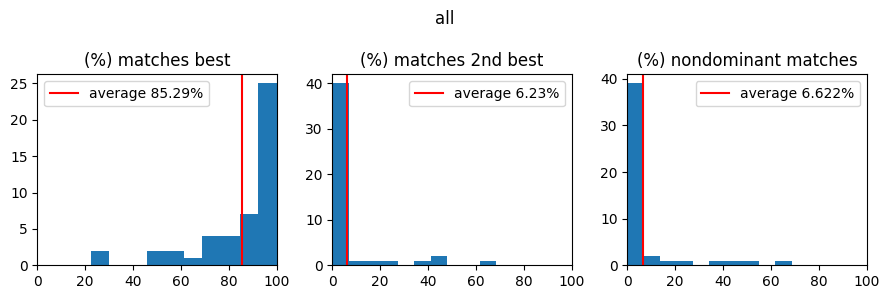

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(9,3))

fig.suptitle("all")
for i, col in enumerate(["(%) matches best", "(%) matches 2nd best", "(%) nondominant matches"]):
    axs[i].hist(object_metrics[col])
    avg =object_metrics[col].mean()
    axs[i].set_title(col)
    axs[i].axvline(x=avg, ymin=0, ymax=1, color="red", label=f"average {avg:.4}%")
    axs[i].set_xlim(0, 100)
    axs[i].legend()
plt.tight_layout()
plt.show()

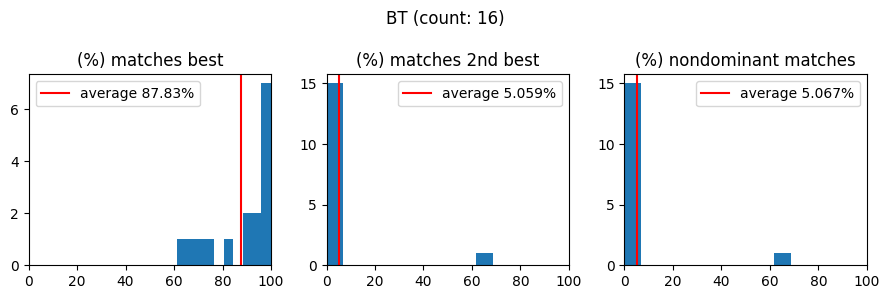

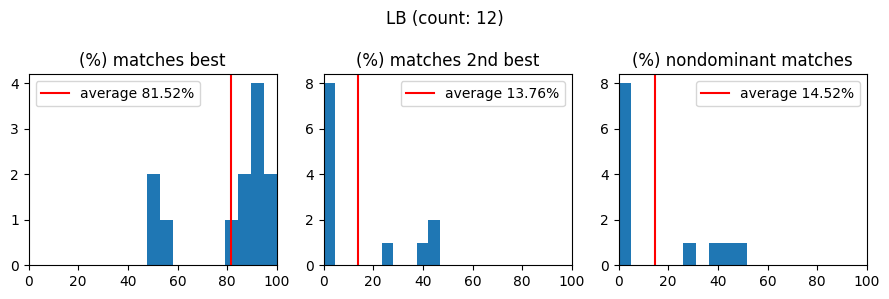

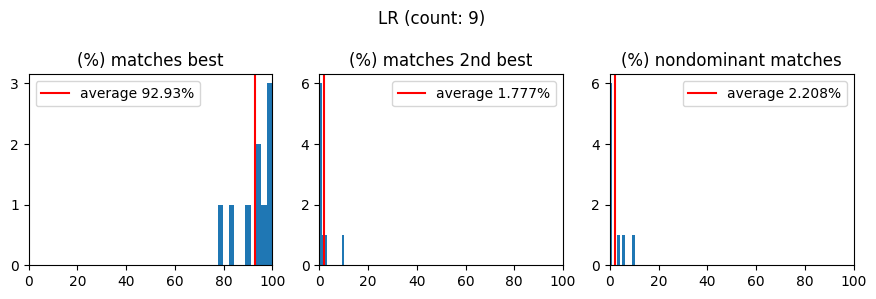

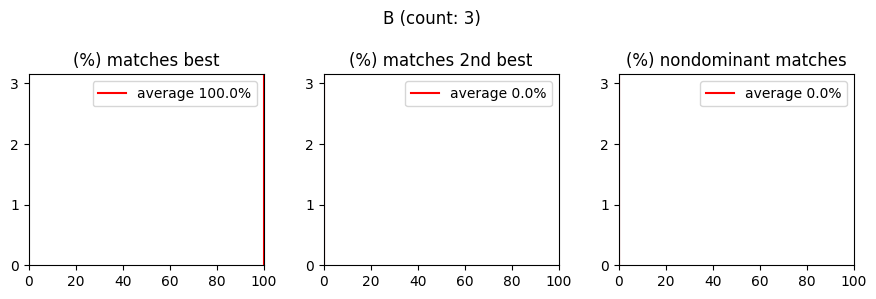

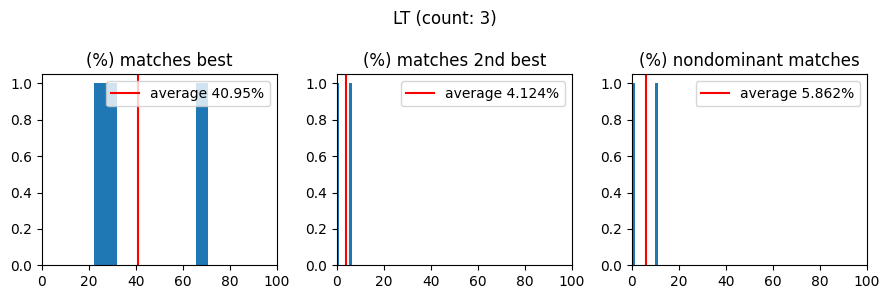

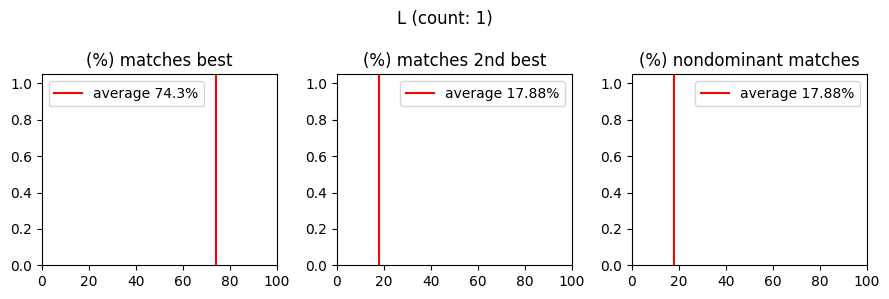

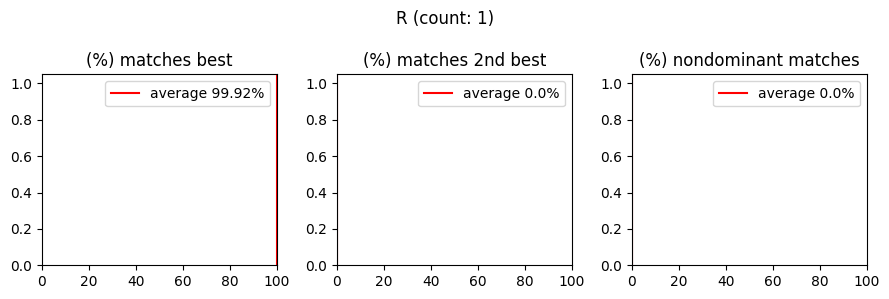

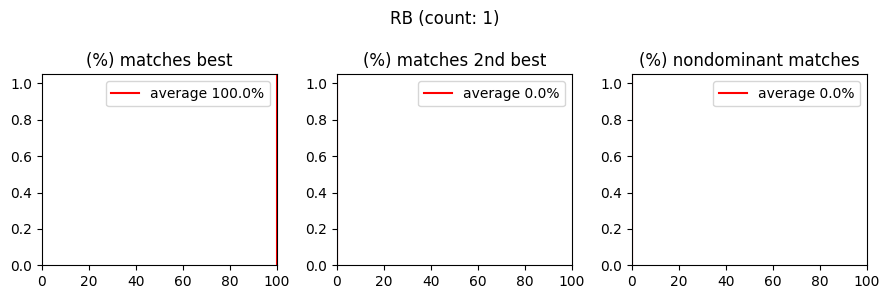

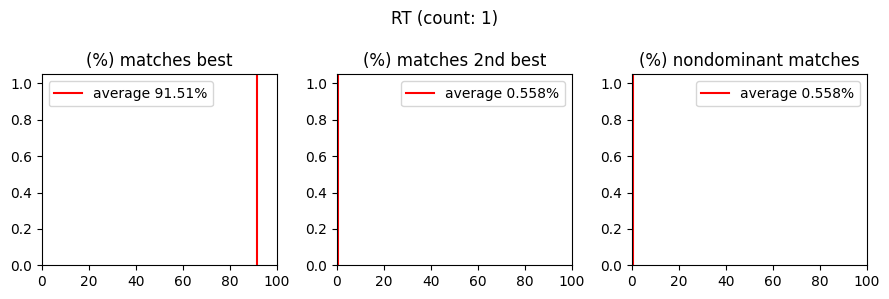

In [ ]:
sorted_groups = sorted(object_metrics.groupby("path type"), key=lambda x: len(x[1]), reverse=True)
for _path_type, _data in sorted_groups:
    fig, axs = plt.subplots(1,3, figsize=(9,3))
    fig.suptitle(_path_type + f" (count: {len(_data)})")
    for i, col in enumerate(["(%) matches best", "(%) matches 2nd best", "(%) nondominant matches"]):
        axs[i].hist(_data[col])
        avg =_data[col].mean()
        axs[i].set_title(col)
        axs[i].axvline(x=avg, ymin=0, ymax=1, color="red", label=f"average {avg:.4}%")
        axs[i].set_xlim(0, 100)
        axs[i].legend()
    plt.tight_layout()
    plt.show()

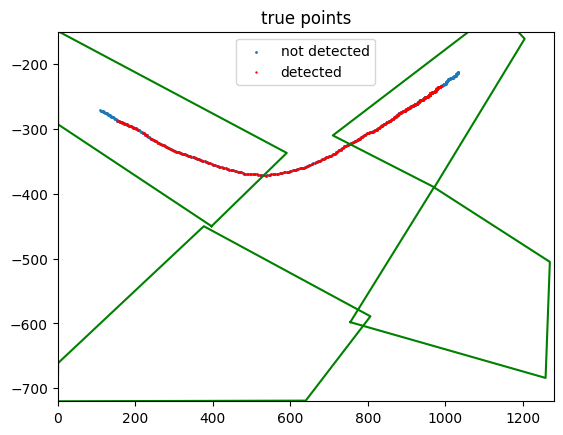

In [ ]:

def check(tp, match):
    plt.title("true points")
    plt.scatter(tp["x"], (-1)*tp["y"], s=1, label="not detected")
    plt.scatter(match["x"], (-1)*match["y"], s=0.5, color="red", label="detected")
    for polygon in [left_area, right_area, bottom_area, top_area]:
        area = np.array(polygon + [polygon[0]])
        plt.plot(area[:, 0], -area[:, 1], color="green")
    plt.xlim(0, 1280)
    plt.ylim(-720,-150)
    plt.legend()
#check(true_points, matching)

check(true_points[true_points["label"] == 25],
      matching[matching["label_true"] == 25])